In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext, SparkConf

conf = (SparkConf()
         .setMaster("local")
         .setAppName("pbl-2")
         .set("spark.executor.cores", "4")) # 코어 수

sc = SparkContext(conf = conf)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

#### 데이터셋 생성 및 변수 정의

(Destination, (Outdegree of Source, Source)) 맵핑

In [4]:
data = sc.textFile("test_dataset.txt").flatMap(lambda file: file.split('\n')).map(lambda line: line.split(' '))
N = data.count()
data = data.flatMap(lambda line: [(i, (len(line[1:]), int(line[0]))) for i in line[1:]])

block = [16, 8, 4, 2, 1]
maxIter = 20
execution_time = []

print(data.take(3))

[('137', (3, 0)), ('781', (3, 0)), ('1', (3, 0))]


In [5]:
def pr_red(partition_data, block_size):
    new_pr = np.zeros(block_size) + 1.5/N
    block_id = -1
    
    for link in partition_data:
        dest = int(link[0])
        outdegree, source = link[1]
        block_id = dest // block_size
        new_pr[dest % block_size] += pr.value[source] / outdegree
        
    for x in range(block_id*block_size, min(N, (block_id+1)*block_size)):
        yield (x, new_pr[x])

#### Block Based Page Rank Calculation

1. destination node id의 범위에 따라 블록 개수만큼 파티션을 나눠준다.
  
  
2. 각 파티션별로 Page Rank를 계산한다.
  
  
3. 모든 파티션의 Page Rank를 합친다.

In [8]:
for block_cnt in block: # block의 개수를 바꿔가며 실행
    start = time.time()
    
    pr = sc.broadcast([ 1. / float(N) for _ in range(N) ]) 
    block_size = (N // block_cnt) if N % block_cnt != 0 else (N // block_cnt)+1
        
    for _ in range(maxIter):
        itr = data.partitionBy(block_cnt, lambda x: int(x[0]) // block_size)\
                    .map(lambda x: (int(x[0]), pr.value[x[1][1]] / x[1][0])).reduceByKey(lambda x, y: x+y).collect()
        
        new_pr = np.zeros(N) + 1.5/N
        for element in itr: new_pr[element[0]] += element[1]

        pr = sc.broadcast(new_pr)
        
    end = time.time()
    execution_time.append(end-start)

    print("the number of blocks: {}".format(block_cnt))
    print("duration: {}".format(end-start))
    print()

the number of blocks: 16
duration: 79.81592845916748

the number of blocks: 8
duration: 63.307430267333984

the number of blocks: 4
duration: 56.5703125

the number of blocks: 2
duration: 52.89344239234924

the number of blocks: 1
duration: 49.15682792663574



#### 그래프

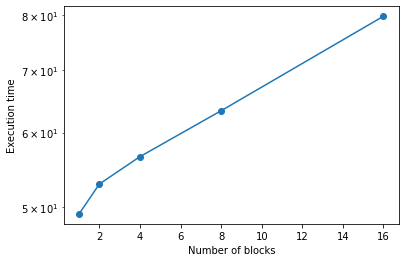

In [9]:
plt.plot(block, execution_time, marker = 'o')

plt.xlabel("Number of blocks")
plt.ylabel("Execution time")

plt.yscale('log')
plt.show()